In [ ]:
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

In [ ]:
# # test a video and show the results
# video = mmcv.VideoReader('video.mp4')
# for frame in video:
#    result = inference_model(model, frame)
#    show_result_pyplot(model, frame, result, wait_time=1)

In [1]:
from mmseg.apis import inference_model, init_model, show_result_pyplot
import mmcv
from glob import glob 
import os 
import numpy as np 
import cv2

In [3]:
# init model
config_file = 'deeplabv3plus_r101_512x512_face-occlusion.py'
checkpoint_file = 'deeplabv3plus_r101_512x512_face-occlusion-93ec6695.pth'
model = init_model(config_file, checkpoint_file, device='cuda:0')

/local/home/yaqqin/miniconda3/envs/work38/lib/python3.8/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/local/home/yaqqin/miniconda3/envs/work38/lib/python3.8/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/local/home/yaqqin/miniconda3/envs/work38/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/lo

Loads checkpoint by local backend from path: deeplabv3plus_r101_512x512_face-occlusion-93ec6695.pth


In [8]:
path = '../dataset/mead_25fps/processed/images/M003/front/angry/level_1/000002.png'
img = cv2.imread(path) 
file_name = os.path.split(path)[-1]
result = inference_model(model, img)
show_result_pyplot(model, img, result, show=True, out_file=f"seg_output/{file_name}", opacity=0.2)

array([[[26, 33, 24],
        [26, 33, 24],
        [26, 33, 24],
        ...,
        [22, 28, 20],
        [22, 28, 20],
        [22, 28, 20]],

       [[26, 33, 24],
        [26, 33, 24],
        [26, 33, 24],
        ...,
        [22, 28, 20],
        [22, 28, 20],
        [22, 28, 20]],

       [[26, 33, 24],
        [26, 33, 24],
        [26, 33, 24],
        ...,
        [22, 28, 20],
        [22, 28, 20],
        [22, 28, 20]],

       ...,

       [[21, 27, 21],
        [21, 27, 21],
        [21, 27, 21],
        ...,
        [21, 25, 20],
        [21, 25, 20],
        [21, 25, 20]],

       [[21, 27, 21],
        [21, 27, 21],
        [21, 27, 21],
        ...,
        [21, 25, 20],
        [21, 25, 20],
        [21, 25, 20]],

       [[21, 27, 21],
        [21, 27, 21],
        [21, 27, 21],
        ...,
        [21, 25, 20],
        [21, 25, 20],
        [21, 25, 20]]], dtype=uint8)

In [38]:
seg_mask = np.asanyarray(result[0].pred_sem_seg.values()[0].cpu())


In [39]:
seg_mask.shape

(1, 1280, 720)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.unique(seg_mask)

array([0])

(1280, 720, 1)


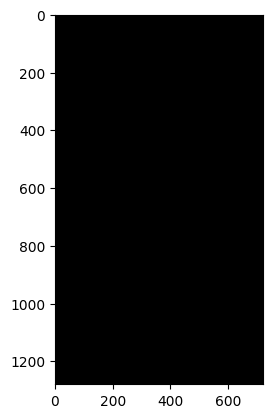

In [11]:
seg_mask = seg_mask[0] * 255
seg_mask = np.expand_dims(seg_mask, axis=-1)
print(seg_mask.shape)
plt.imshow(seg_mask, cmap='gray')

In [17]:
import face_alignment
from skimage.transform import warp, estimate_transform

In [16]:

# landmark detector
face_detector_kwargs = {
    'back_model': False
}

face_detector = face_alignment.FaceAlignment(
    face_alignment.LandmarksType.TWO_D, 
    flip_input=False,
    face_detector='blazeface',    # support detectors ['dlib', 'blazeface', 'cfd]
    face_detector_kwargs = face_detector_kwargs,
    device='cuda',)

In [19]:
def crop_face(landmarks):
    scale = 1.5
    image_size = 224
    left = np.min(landmarks[:, 0])
    right = np.max(landmarks[:, 0])
    top = np.min(landmarks[:, 1])
    bottom = np.max(landmarks[:, 1])
    old_size = (right - left + bottom - top) / 2
    center = np.array([right - (right - left) / 2.0, bottom - (bottom - top) / 2.0])  # + old_size*0.1])

    size = int(old_size * scale)

    # crop image
    src_pts = np.array([[center[0] - size / 2, center[1] - size / 2], [center[0] - size / 2, center[1] + size / 2],
                        [center[0] + size / 2, center[1] - size / 2]])
    DST_PTS = np.array([[0, 0], [0, image_size - 1], [image_size - 1, 0]])
    tform = estimate_transform('similarity', src_pts, DST_PTS)

    return tform

In [20]:
lmks, scores, bbox = face_detector.get_landmarks_from_image(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB), return_bboxes=True, return_landmark_score=True)
kpt = lmks[0]
tform = crop_face(kpt)
cropped_kpt = np.dot(tform.params, np.hstack([kpt, np.ones([kpt.shape[0],1])]).T).T
cropped_image = warp(img, tform.inverse, output_shape=(224,224))
cropped_image_rgb = cropped_image.transpose(2,0,1)[[2,1,0],:,:] # (3, 224, 224) in RGB

In [21]:
warped_mask = warp(seg_mask[:,:,0], tform.inverse, output_shape=(224,224))

In [24]:
warped_mask[warped_mask > 0] = 1

In [25]:
np.unique(warped_mask)

array([0., 1.])

In [27]:
import torch

In [28]:
encoder = torch.hub.load('pytorch/vision:v0.8.1', 'mobilenet_v2', pretrained=True)

Using cache found in /local/home/yaqqin/.cache/torch/hub/pytorch_vision_v0.8.1


In [32]:
cropped_image_rgb.shape

(3, 224, 224)

In [33]:
image = torch.from_numpy(cropped_image_rgb).float().unsqueeze(0)
emb = encoder.features(image)